In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Set the paths for the train and test sets
trainset_path = '/content/drive/MyDrive/datasets/trainset'
testset_path = '/content/drive/MyDrive/datasets/testset'

# Print class names and number of images in the trainset
print("Trainset:")
for mosquito_class in os.listdir(trainset_path):
    class_path = os.path.join(trainset_path, mosquito_class)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        # Get the list of images for the current class
        images = [img for img in os.listdir(class_path) if img.endswith(".jpg")]

        # Print class name and number of images
        print(f"{mosquito_class}: {len(images)} images")

# Print a separator
print("\n" + "="*40 + "\n")

# Print class names and number of images in the testset
print("Testset:")
for mosquito_class in os.listdir(testset_path):
    class_path = os.path.join(testset_path, mosquito_class)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        # Get the list of images for the current class
        images = [img for img in os.listdir(class_path) if img.endswith(".jpg")]

        # Print class name and number of images
        print(f"{mosquito_class}: {len(images)} images")


Trainset:
Anopheles Albimanus: 400 images
Anopheles Atroparvus: 400 images
Culex Quinquefasciatus: 400 images
Anopheles Freeborni: 400 images
Aedes Aegypti: 400 images
Anopheles Arabiensis: 400 images
Anopheles Farauti: 400 images
Anopheles Coluzzi: 400 images
Anopheles Stephensi: 400 images
Aedes Albopictus: 400 images


Testset:
Culex Quinquefasciatus: 100 images
Anopheles Stephensi: 100 images
Anopheles Freeborni: 100 images
Anopheles Farauti: 100 images
Anopheles Coluzzi: 100 images
Anopheles Atroparvus: 100 images
Anopheles Albimanus: 100 images
Aedes Aegypti: 100 images
Anopheles Arabiensis: 100 images
Aedes Albopictus: 100 images


GPU is available and being used for training.
Found 4000 images belonging to 10 classes.
Found 1000 files belonging to 10 classes.
94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/20
125/125 [==============================] - 1346s 11s/step - loss: 1.5466 - accuracy: 0.4530 - val_loss: 0.8379 - val_accuracy: 0.7640
Epoch 2/20
125/125 [==============================] - 98s 789ms/step - loss: 0.9002 - accuracy: 0.6747 - val_loss: 0.6109 - val_accuracy: 0.8130
Epoch 3/20
125/125 [==============================] - 96s 770ms/step - loss: 0.7046 - accuracy: 0.7400 - val_loss: 0.5123 - val_accuracy: 0.8360
Epoch 4/20
125/125 [==============================] - 99s 793ms/step - loss: 0.5990 - accuracy: 0.7820 - val_loss: 0.4283 - val_accuracy: 0.8700
Epoch 5/20
125/125 [==============================] - 96s 769ms/step - loss: 0.5416 - accuracy: 0.8033 - val_loss: 0.4002 - val_accuracy: 0.8780
Epoch 6/20
125/125 [==============================] - 99s 789ms/step - loss: 0.

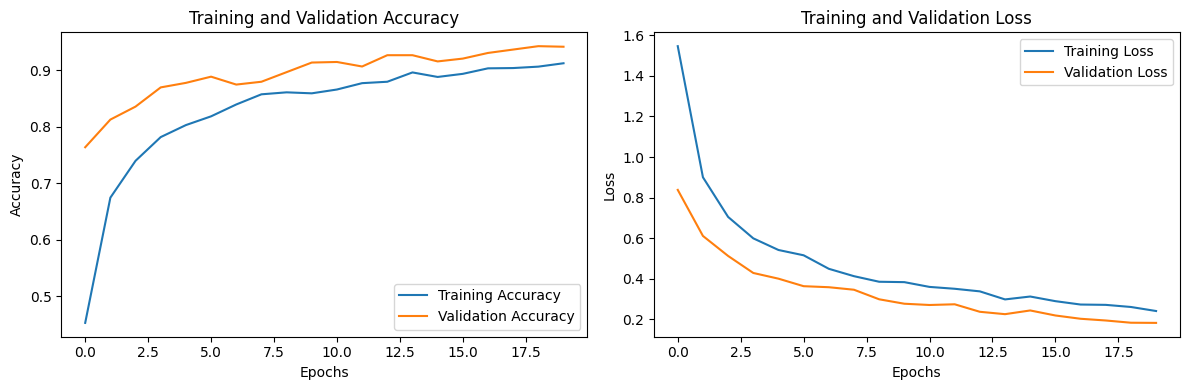

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Define your dataset directories
train_data_dir = '/content/drive/MyDrive/datasets/trainset'
val_data_dir = '/content/drive/MyDrive/datasets/testset'

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

import tensorflow as tf

# Check if GPU is available and being used
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used for training.")
else:
    print("GPU is not available. Training on CPU.")

# Load the dataset with data augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

num_classes = len(train_ds.class_indices)

# Define the model
pretrained_model = ResNet50(
    include_top=False,
    input_shape=(img_height, img_width, 3),
    pooling='avg',
    weights='imagenet'
)

model = Sequential([
    pretrained_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout regularization
    layers.Dense(num_classes, activation='softmax')  # Output layer with 'num_classes' units
])

# Freeze the pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model with a different learning rate
optimizer = Adam(learning_rate=0.0001)  # Changed learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 20

# ModelCheckpoint callback to save the best model during training
checkpoint_path = '/content/drive/MyDrive/mosquito_model2'  # Change the path as needed
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[checkpoint]  # Include the ModelCheckpoint callback
)

# Get the model name
model_name = checkpoint_path.split('/')[-1]

# Print the model name along with its accuracy
print(f"Model {model_name} saved with Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50

# Define ResNet50 model
pretrained_model = ResNet50(weights='imagenet', include_top=False)

# Calculate the number of parameters
num_params = sum([layer.count_params() for layer in pretrained_model.layers])

# Convert the number of parameters to millions
num_params_millions = num_params / 1e6

# Print the number of parameters in millions
print(f"Number of parameters in ResNet50: {num_params_millions:.2f} million")


94765736/94765736 [==============================] - 1s 0us/step
Number of parameters in ResNet50: 23.59 million


In [ ]:
import torch
from transformers import MobileViTForImageClassification

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small').to(device)

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Convert the number of parameters to millions
num_params_millions = num_params / 1e6

# Print the number of parameters in millions
print(f"Number of parameters in MobileViT: {num_params_millions:.2f} million")


Number of parameters in MobileViT: 5.58 million


In [ ]:
from tensorflow.keras.applications import Xception

# Load the Xception model
model = Xception()

# Count the number of parameters
num_params = model.count_params()

# Convert the number of parameters to millions
num_params_millions = num_params / 1e6

# Print the number of parameters in millions
print(f"Number of parameters in Xception: {num_params_millions:.2f} million")


91884032/91884032 [==============================] - 1s 0us/step
Number of parameters in Xception: 22.91 million


1/1 [==============================] - 1s 1s/step
Confusion Matrix:
[[0.93 0.   0.02 0.02 0.   0.01 0.   0.02 0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.96 0.   0.01 0.   0.03 0.   0.   0.  ]
 [0.01 0.   0.   0.91 0.   0.08 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.93 0.   0.06 0.01 0.   0.  ]
 [0.01 0.   0.01 0.16 0.   0.82 0.   0.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.98 0.   0.   0.  ]
 [0.   0.   0.02 0.   0.05 0.   0.01 0.92 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.98]]


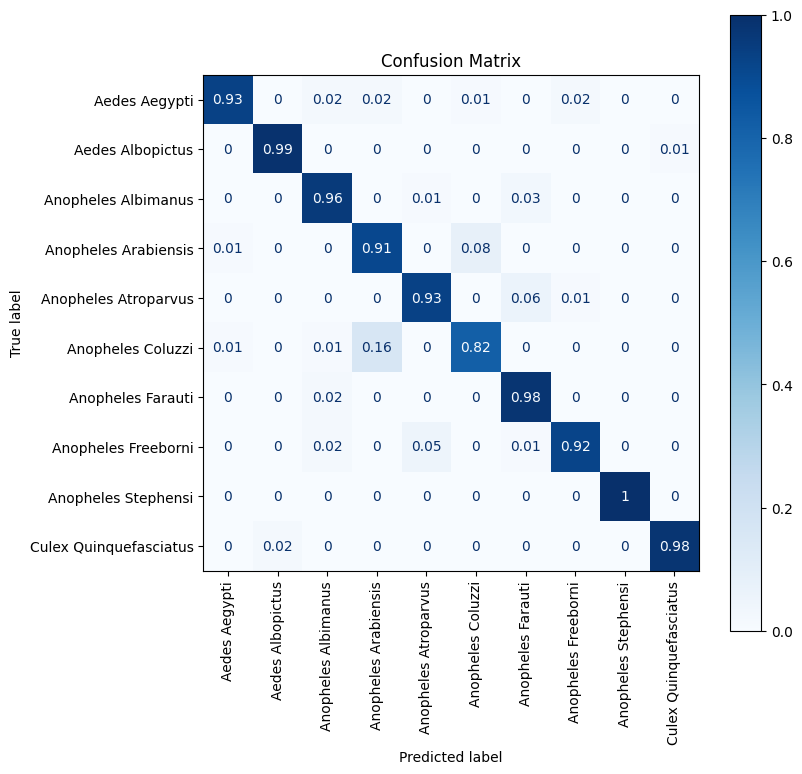

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define class names manually
class_names = ['Aedes Aegypti', 'Aedes Albopictus','Anopheles Albimanus','Anopheles Arabiensis','Anopheles Atroparvus','Anopheles Coluzzi','Anopheles Farauti','Anopheles Freeborni','Anopheles Stephensi', 'Culex Quinquefasciatus']

# Get the true labels and predictions for the validation set
val_true_labels = []
val_predictions = []

for images, labels in val_ds:
    val_true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    val_predictions.extend(np.argmax(predictions, axis=1))

# Create the confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions, normalize='true')

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


Checking result for class Aedes Aegypti

Saving Aedes Aegypti_29.jpg to Aedes Aegypti_29.jpg
1/1 [==============================] - 4s 4s/step


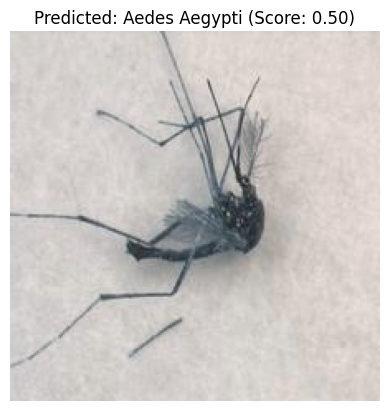

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Checking result for class Aedes Albopictus

Saving 42.jpg to 42.jpg
1/1 [==============================] - 1s 999ms/step


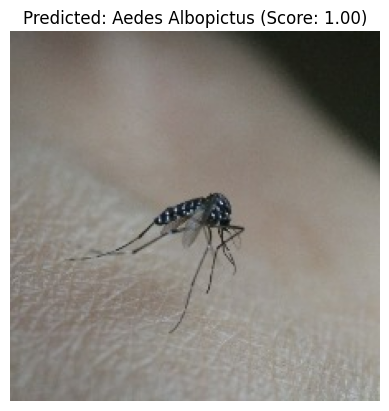

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Albimanus_augmented_25.jpg to Anopheles Albimanus_augmented_25.jpg
1/1 [==============================] - 1s 1s/step


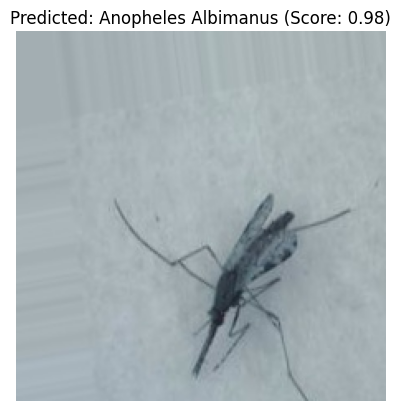

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Arabiensis_augmented_77.jpg to Anopheles Arabiensis_augmented_77.jpg
1/1 [==============================] - 1s 920ms/step


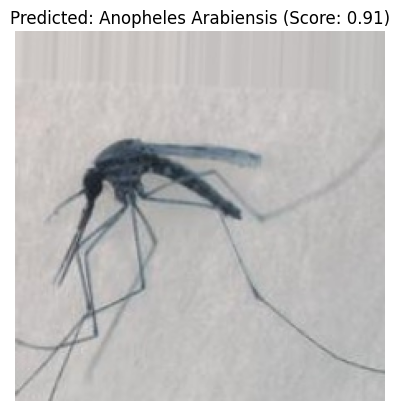

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Atroparvus_augmented_36.jpg to Anopheles Atroparvus_augmented_36.jpg


1/1 [==============================] - 1s 953ms/step


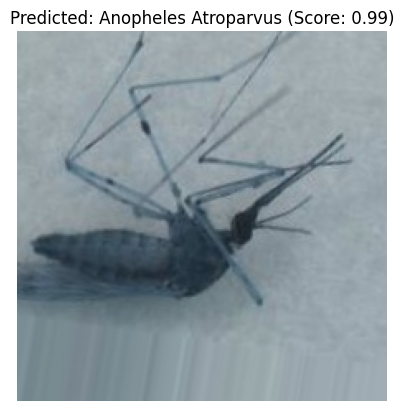

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Coluzzi_augmented_45.jpg to Anopheles Coluzzi_augmented_45.jpg


1/1 [==============================] - 1s 1s/step


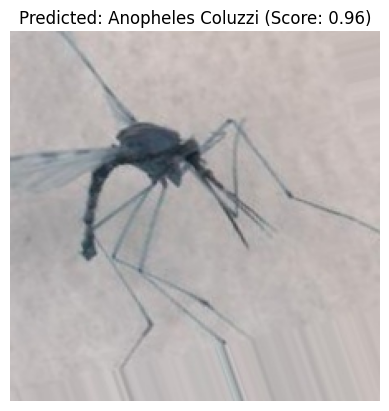

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Farauti_augmented_54.jpg to Anopheles Farauti_augmented_54.jpg
1/1 [==============================] - 1s 1s/step


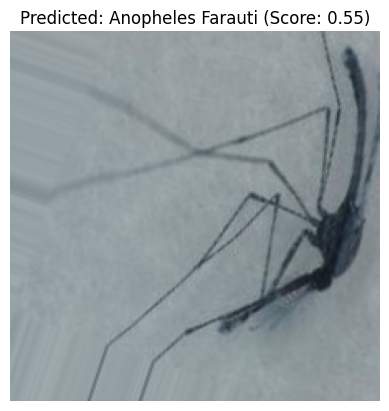

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Freeborni_augmented_2.jpg to Anopheles Freeborni_augmented_2.jpg
1/1 [==============================] - 1s 936ms/step


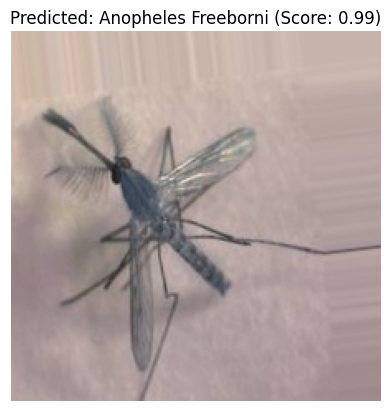

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving Anopheles Stephensi_augmented_64.jpg to Anopheles Stephensi_augmented_64.jpg
1/1 [==============================] - 2s 2s/step


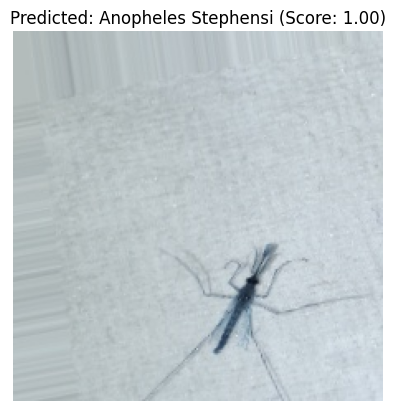

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


Saving 25s.jpg to 25s.jpg
1/1 [==============================] - 1s 975ms/step


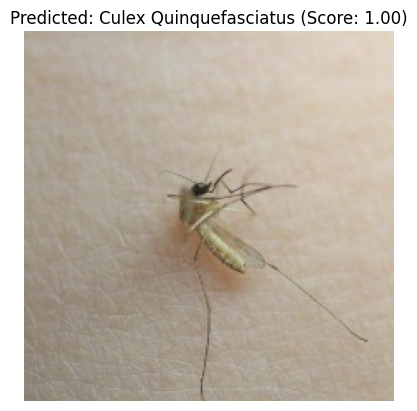

In [ ]:
from google.colab import drive
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Define the path to the saved model files in Google Drive
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'

# Load the model
model = tf.keras.models.load_model(model_path)

# Define the image dimensions
img_height, img_width = 224, 224  # Adjust these dimensions based on your model requirements

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Define the prediction function
def predict_image_class(image):
    resized_image = cv2.resize(image, (img_height, img_width))
    img_array = np.expand_dims(resized_image, axis=0)
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions)
    predicted_class_name = class_names[class_index]
    score = np.max(predictions)  # Get the maximum score as the prediction confidence
    return class_index, predicted_class_name, score

# Handle image upload
uploaded = files.upload()
for fn in uploaded.keys():
    img = Image.open(fn)
    img = np.array(img)
    prediction_index, prediction_name, prediction_score = predict_image_class(img)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {prediction_name} (Score: {prediction_score:.2f})')
    plt.show()


OPENMAX Implementation

FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 1s/step
Recalibrated Scores:
Aedes Aegypti: 0.0429
Aedes Albopictus: 0.9860
Anopheles Albimanus: 0.9991
Anopheles Arabiensis: 0.9999
Anopheles Atroparvus: 0.9994
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9990
Anopheles Freeborni: 0.9962
Anopheles Stephensi: 0.9999
Culex Quinquefasciatus: 0.9775


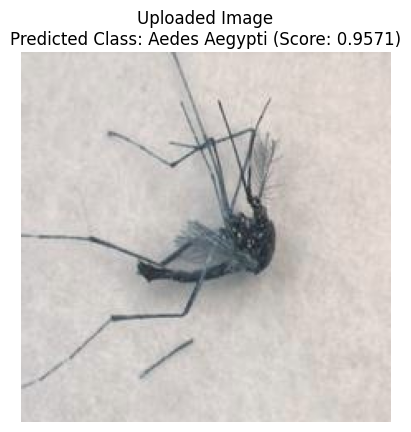

1/1 [==============================] - 0s 42ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9994
Aedes Albopictus: 0.0155
Anopheles Albimanus: 0.9993
Anopheles Arabiensis: 0.9997
Anopheles Atroparvus: 0.9996
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9986
Anopheles Freeborni: 0.9994
Anopheles Stephensi: 0.9998
Culex Quinquefasciatus: 0.9887


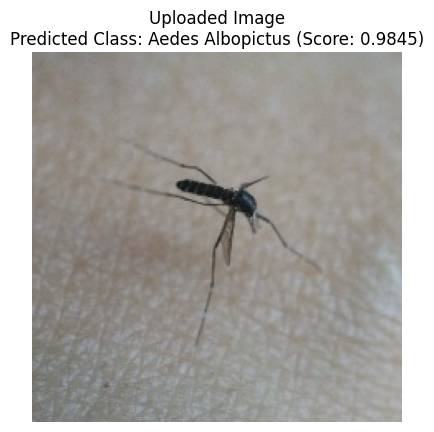

1/1 [==============================] - 0s 33ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9993
Aedes Albopictus: 0.9112
Anopheles Albimanus: 0.2975
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 0.9996
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9993
Anopheles Freeborni: 0.9984
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.7947


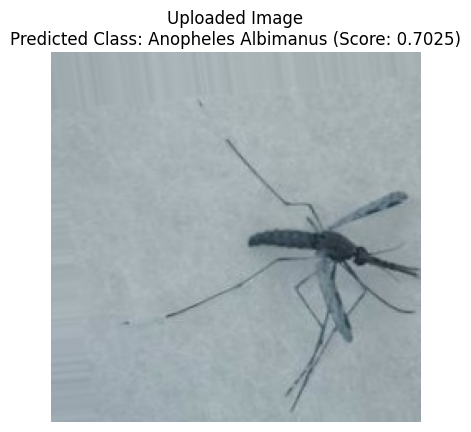

1/1 [==============================] - 0s 25ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9946
Aedes Albopictus: 0.8633
Anopheles Albimanus: 0.7683
Anopheles Arabiensis: 0.9956
Anopheles Atroparvus: 0.9996
Anopheles Coluzzi: 0.9998
Anopheles Farauti: 0.9985
Anopheles Freeborni: 0.9983
Anopheles Stephensi: 0.9999
Culex Quinquefasciatus: 0.3822


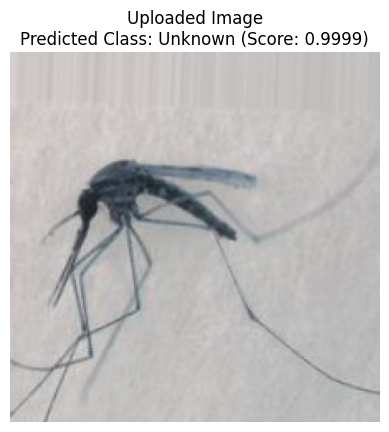

1/1 [==============================] - 0s 26ms/step
Recalibrated Scores:
Aedes Aegypti: 0.5346
Aedes Albopictus: 0.9485
Anopheles Albimanus: 0.9982
Anopheles Arabiensis: 0.9985
Anopheles Atroparvus: 0.7029
Anopheles Coluzzi: 0.9995
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.9988
Anopheles Stephensi: 0.9999
Culex Quinquefasciatus: 0.8190


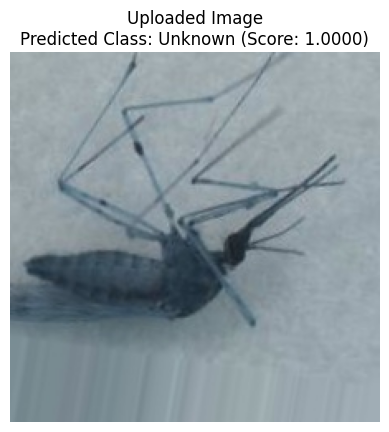

1/1 [==============================] - 0s 37ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9992
Aedes Albopictus: 0.9597
Anopheles Albimanus: 0.9649
Anopheles Arabiensis: 0.9998
Anopheles Atroparvus: 0.9998
Anopheles Coluzzi: 0.9998
Anopheles Farauti: 0.9991
Anopheles Freeborni: 0.9987
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.0791


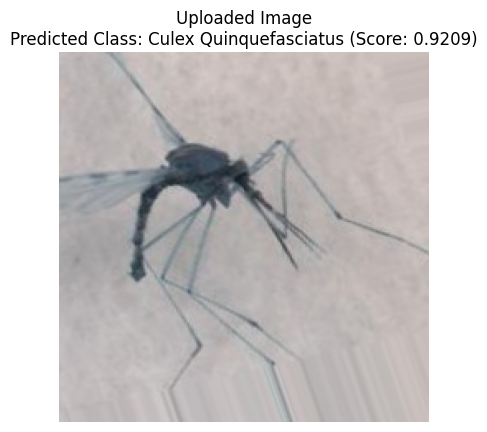

1/1 [==============================] - 0s 25ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9993
Aedes Albopictus: 0.9615
Anopheles Albimanus: 0.7355
Anopheles Arabiensis: 0.9980
Anopheles Atroparvus: 0.9985
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9954
Anopheles Freeborni: 0.9995
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.3123


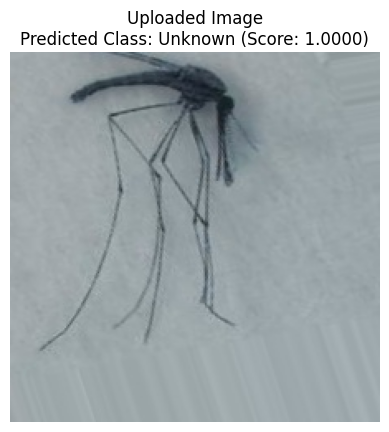

1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9549
Aedes Albopictus: 0.9691
Anopheles Albimanus: 0.9764
Anopheles Arabiensis: 0.9992
Anopheles Atroparvus: 0.9873
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9994
Anopheles Freeborni: 0.2207
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.8930


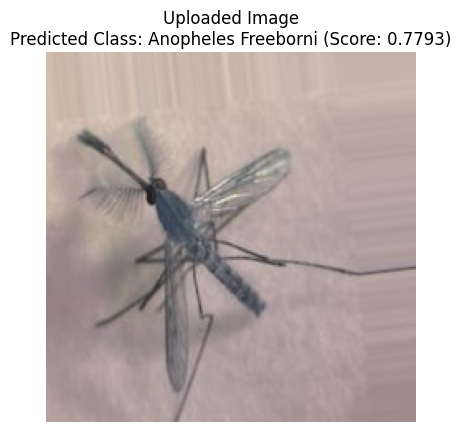

1/1 [==============================] - 0s 25ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9999
Aedes Albopictus: 0.4269
Anopheles Albimanus: 0.8168
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 0.9996
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9999
Anopheles Freeborni: 0.9999
Anopheles Stephensi: 0.9997
Culex Quinquefasciatus: 0.7572


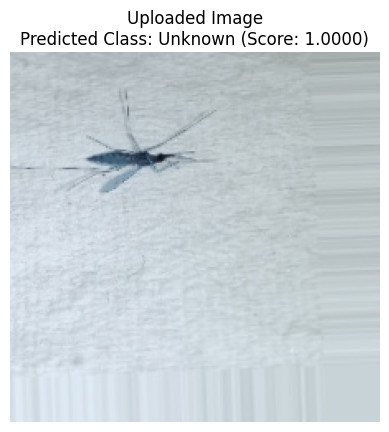

1/1 [==============================] - 0s 23ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9999
Aedes Albopictus: 0.9712
Anopheles Albimanus: 0.9773
Anopheles Arabiensis: 0.9995
Anopheles Atroparvus: 0.1475
Anopheles Coluzzi: 0.9999
Anopheles Farauti: 0.9746
Anopheles Freeborni: 0.9335
Anopheles Stephensi: 0.9998
Culex Quinquefasciatus: 0.9966


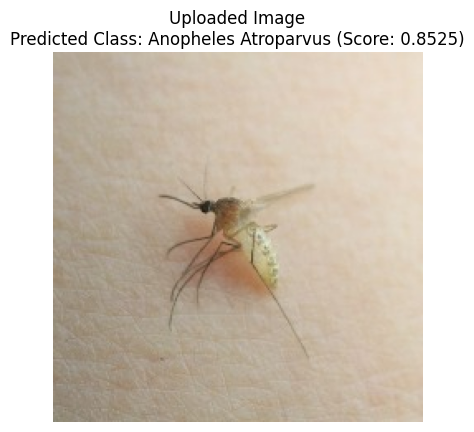

1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.4181
Aedes Albopictus: 0.9937
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 0.9999
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.5883


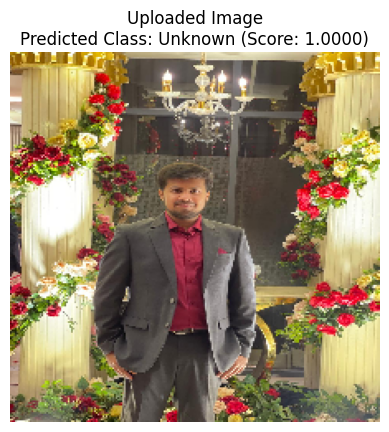

1/1 [==============================] - 0s 33ms/step
Recalibrated Scores:
Aedes Aegypti: 0.4783
Aedes Albopictus: 0.7926
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 0.7311
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 0.9981
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 1.0000


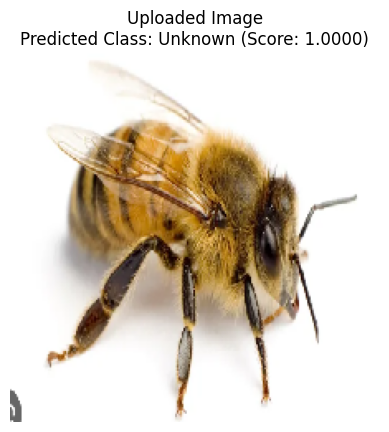

1/1 [==============================] - 0s 25ms/step
Recalibrated Scores:
Aedes Aegypti: 0.6901
Aedes Albopictus: 0.3106
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 0.9999
Culex Quinquefasciatus: 0.9994


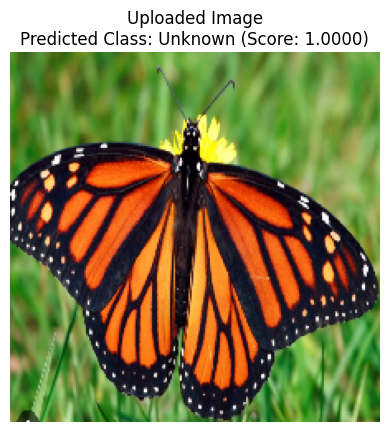

1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9999
Aedes Albopictus: 0.0061
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.9940


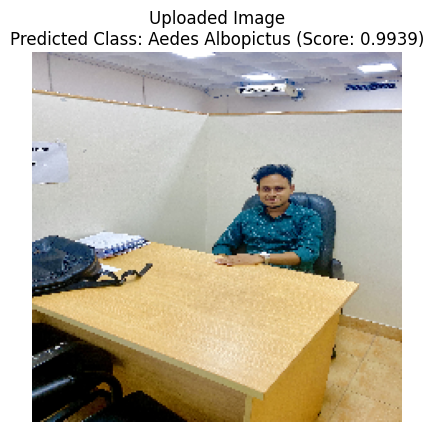

1/1 [==============================] - 0s 37ms/step
Recalibrated Scores:
Aedes Aegypti: 0.8938
Aedes Albopictus: 0.1065
Anopheles Albimanus: 0.9999
Anopheles Arabiensis: 0.9999
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 0.9999
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.9999
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 1.0000


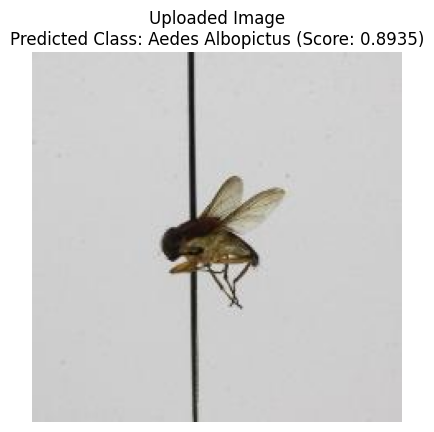

1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.0144
Aedes Albopictus: 0.9868
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 0.9999
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.9999
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.9990


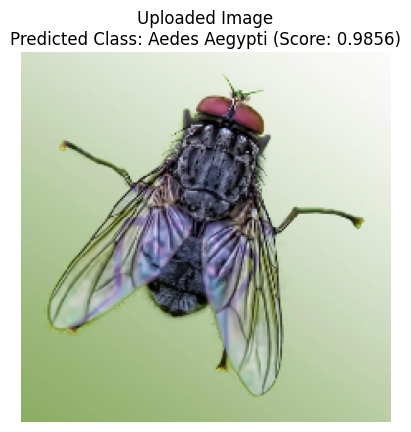

1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9999
Aedes Albopictus: 0.4804
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 0.9970
Anopheles Atroparvus: 0.9994
Anopheles Coluzzi: 0.9998
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.5236


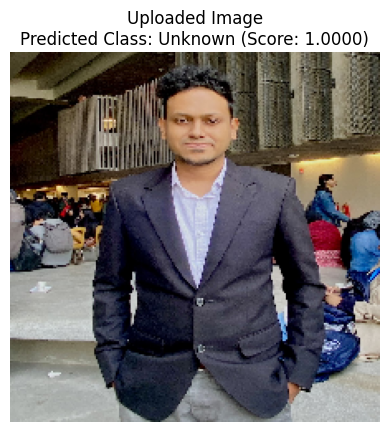

1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9386
Aedes Albopictus: 0.0658
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.9956


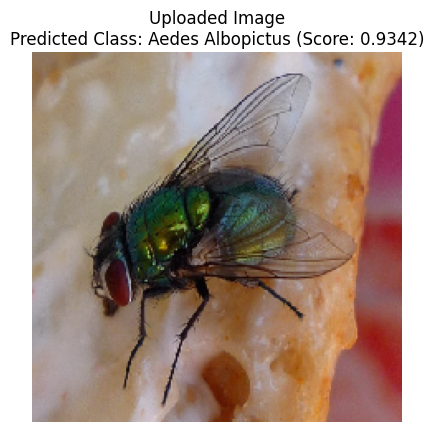

In [ ]:
import numpy as np
import io
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow import keras
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Load the trained ResNet50 model
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'
model = keras.models.load_model(model_path)

def openmax_single_image(img):
    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get model's prediction
    prediction = model.predict(img_array)

    # Implement OpenMax here...
    # For simplicity, let's assume OpenMax recalibration as inverse of the normalized softmax
    softmax_scores = prediction[0]
    normalized_scores = softmax_scores / np.sum(softmax_scores)
    recalibrated_scores = 1 - normalized_scores

    # Threshold for unknown class
    unknown_threshold = 0.7  # Adjust as needed

    # If the maximum score is below the unknown threshold, classify as "Unknown"
    if np.max(softmax_scores) < unknown_threshold:
        result = "Unknown"
        max_score = np.max(recalibrated_scores)
    else:
        max_index = np.argmax(softmax_scores)
        result = class_names[max_index]
        max_score = softmax_scores[max_index]

    print("Recalibrated Scores:")
    for i, score in enumerate(recalibrated_scores):
        print(f"{class_names[i]}: {score:.4f}")

    return result, max_score

# Create an image uploader
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def on_upload_change(change):
    # When file is uploaded, get the image data and call openmax_single_image
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']

    # Load the uploaded image
    img = image.load_img(io.BytesIO(content), target_size=(224, 224))

    # Call openmax_single_image function
    result, max_score = openmax_single_image(img)

    # Display the uploaded image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Uploaded Image\nPredicted Class: {result} (Score: {max_score:.4f})')
    plt.show()

uploader.observe(on_upload_change, names='_counter')


FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 941ms/step
Recalibrated Scores:
Aedes Aegypti: 0.4783
Aedes Albopictus: 0.7926
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 0.7311
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 0.9981
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 1.0000


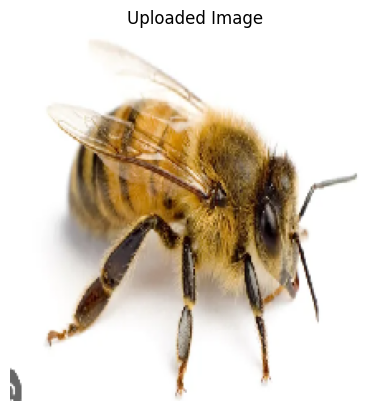

Predicted Class: Unknown
1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.0090
Aedes Albopictus: 0.9952
Anopheles Albimanus: 0.9991
Anopheles Arabiensis: 0.9999
Anopheles Atroparvus: 0.9998
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9991
Anopheles Freeborni: 0.9990
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.9989


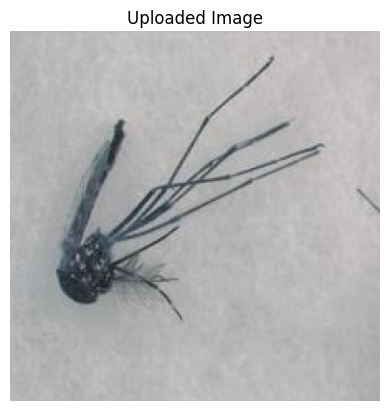

Predicted Class: Aedes Aegypti
1/1 [==============================] - 0s 25ms/step
Recalibrated Scores:
Aedes Aegypti: 0.5346
Aedes Albopictus: 0.9485
Anopheles Albimanus: 0.9982
Anopheles Arabiensis: 0.9985
Anopheles Atroparvus: 0.7029
Anopheles Coluzzi: 0.9995
Anopheles Farauti: 1.0000
Anopheles Freeborni: 0.9988
Anopheles Stephensi: 0.9999
Culex Quinquefasciatus: 0.8190


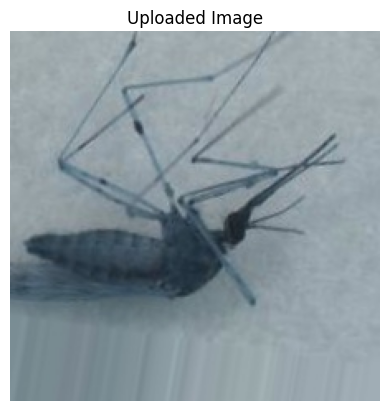

Predicted Class: Unknown
1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9999
Aedes Albopictus: 0.9712
Anopheles Albimanus: 0.9773
Anopheles Arabiensis: 0.9995
Anopheles Atroparvus: 0.1475
Anopheles Coluzzi: 0.9999
Anopheles Farauti: 0.9746
Anopheles Freeborni: 0.9335
Anopheles Stephensi: 0.9998
Culex Quinquefasciatus: 0.9966


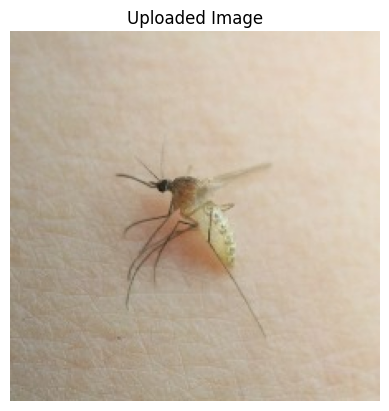

Predicted Class: Anopheles Atroparvus
1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.9976
Aedes Albopictus: 0.9988
Anopheles Albimanus: 0.9024
Anopheles Arabiensis: 0.9999
Anopheles Atroparvus: 0.9948
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 0.9999
Anopheles Freeborni: 0.1120
Anopheles Stephensi: 1.0000
Culex Quinquefasciatus: 0.9946


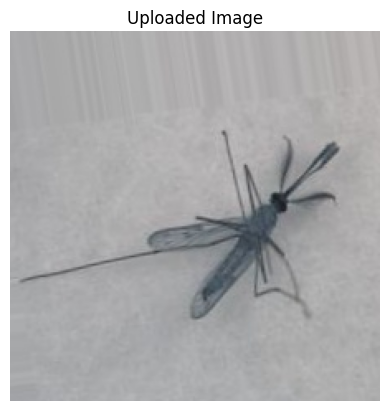

Predicted Class: Anopheles Freeborni
1/1 [==============================] - 0s 24ms/step
Recalibrated Scores:
Aedes Aegypti: 0.6901
Aedes Albopictus: 0.3106
Anopheles Albimanus: 1.0000
Anopheles Arabiensis: 1.0000
Anopheles Atroparvus: 1.0000
Anopheles Coluzzi: 1.0000
Anopheles Farauti: 1.0000
Anopheles Freeborni: 1.0000
Anopheles Stephensi: 0.9999
Culex Quinquefasciatus: 0.9994


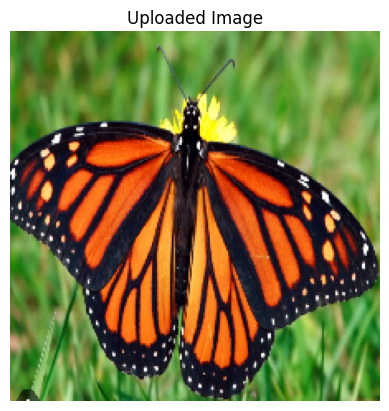

Predicted Class: Unknown


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from scipy.spatial import distance
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
import io

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Load the trained ResNet50 model
model_path = '/content/drive/MyDrive/mosquito_model2'
model = keras.models.load_model(model_path)

def openmax_single_image(img):
    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Get model's prediction
    prediction = model.predict(img_array)

    # Implement OpenMax here...
    # For simplicity, let's assume OpenMax recalibration as inverse of the normalized softmax
    softmax_scores = prediction[0]
    normalized_scores = softmax_scores / np.sum(softmax_scores)
    recalibrated_scores = 1 - normalized_scores

    # Threshold for unknown class
    unknown_threshold = 0.7  # Adjust as needed

    # If the maximum score is below the unknown threshold, classify as "Unknown"
    if np.max(softmax_scores) < unknown_threshold:
        result = "Unknown"
    else:
        result = class_names[np.argmax(softmax_scores)]

    print("Recalibrated Scores:")
    for i, score in enumerate(recalibrated_scores):
        print(f"{class_names[i]}: {score:.4f}")

    return result, recalibrated_scores

# Create an image uploader
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

def on_upload_change(change):
    # When file is uploaded, get the image data and call openmax_single_image
    uploaded_filename = next(iter(uploader.value))
    content = uploader.value[uploaded_filename]['content']

    # Load the uploaded image
    img = image.load_img(io.BytesIO(content), target_size=(224, 224))

    # Call openmax_single_image function
    result, recalibrated_scores = openmax_single_image(img)

    # Display the uploaded image
    plt.imshow(img)
    plt.axis('off')
    plt.title('Uploaded Image')
    plt.show()

    # Display result
    print("Predicted Class:", result)

uploader.observe(on_upload_change, names='_counter')


Found 1000 images belonging to 10 classes.
32/32 [==============================] - 183s 6s/step


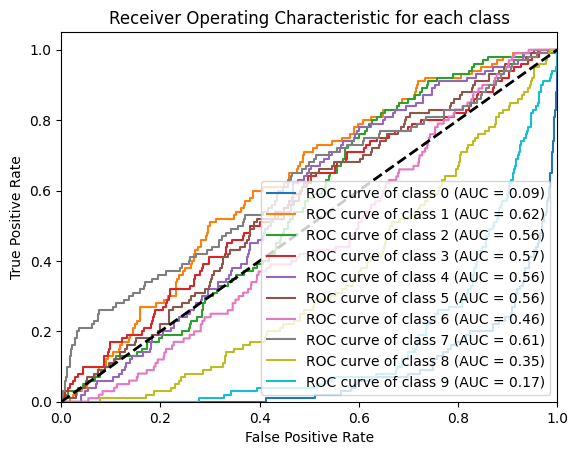

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

# Define image dimensions
img_height, img_width = 224, 224  # Example dimensions, adjust according to your model's input size

# Define batch size
batch_size = 32  # Example batch size, adjust according to your training configuration

# Define the class names
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']

# Calculate the number of classes
num_classes = len(class_names)

# Load the trained model
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'
model = load_model(model_path)

# Path to your dataset
train_data_dir = '/content/drive/MyDrive/datasets/trainset'
val_data_dir = '/content/drive/MyDrive/datasets/testset'

# Use the ImageDataGenerator used during training if you applied any specific augmentations or preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)  # Assuming you normalized images in training by rescaling

# Use flow_from_directory to generate validation data
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # Important: keep data in same order as labels
)

# Calculate predictions for the entire validation set
num_val_samples = val_generator.samples
val_steps = num_val_samples // batch_size + (1 if num_val_samples % batch_size else 0)

val_labels = val_generator.classes
predictions = model.predict(val_generator, steps=val_steps)

# Get the true binary labels and the predicted probabilities
y_true = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
y_pred = predictions

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


Found 1000 images belonging to 10 classes.
32/32 [==============================] - 189s 6s/step


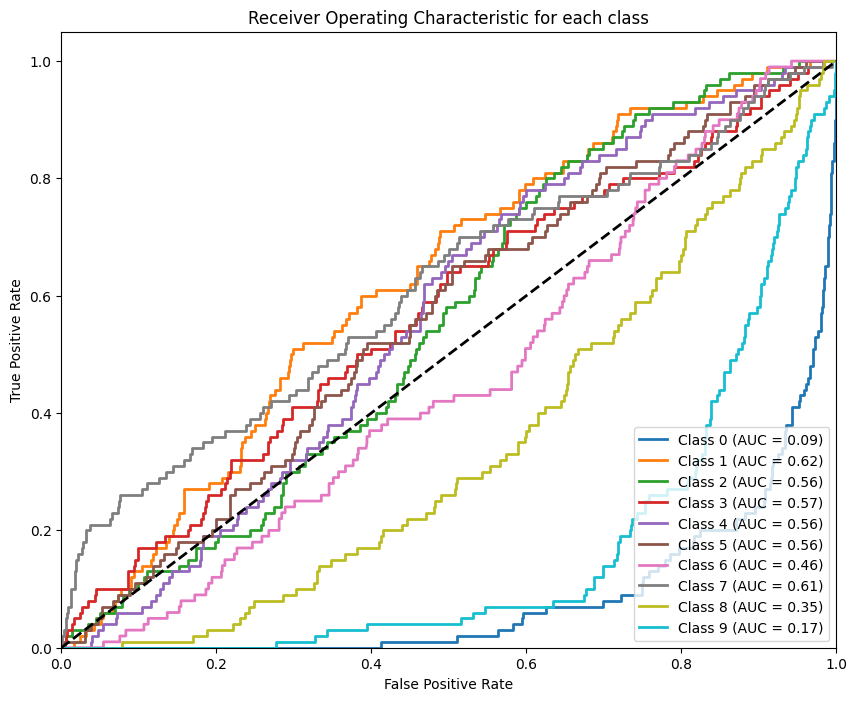

In [ ]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Define your dataset directories
val_data_dir = '/content/drive/MyDrive/datasets/testset'  # Or rename to test_data_dir if appropriate

# Image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Load the model
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'
model = load_model(model_path)

# Load the validation/test data
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# Get the number of classes from the validation/test data generator
num_classes = len(val_generator.class_indices)

# Predict the probabilities on the validation/test set
val_generator.reset()  # To ensure the order of predictions matches the labels
predictions = model.predict(val_generator, steps=val_generator.n // val_generator.batch_size + 1)

# Get the true labels
y_true = val_generator.classes
y_true = label_binarize(y_true, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle

# Load your fine-tuned model
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'
model = load_model(model_path)

# Assuming the model outputs softmax probabilities, let's modify it to output logits
# Typically, the logits are the inputs to the final softmax activation layer
logits_layer = model.layers[-2].output  # This assumes the second last layer is the logits layer
logits_model = Model(inputs=model.input, outputs=logits_layer)

# Load dataset
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/datasets/trainset',
    target_size=(224, 224),
    batch_size=1,  # Processing one image at a time for MAV calculation
    class_mode='sparse',
    shuffle=False  # To maintain label order
)

# Extract logits and labels from training data
logits = []
labels = []
for images, label in train_generator:
    log = logits_model.predict(images)
    logits.append(log.flatten())
    labels.append(label[0])
    if len(labels) >= len(train_generator.labels):
        break

logits = np.array(logits)
labels = np.array(labels)

# Calculate MAVs and distances for each class
mavs = []
distances = []
for i in range(num_classes):
    class_indices = np.where(labels == i)[0]
    class_logits = logits[class_indices]
    mav = np.mean(class_logits, axis=0)
    mavs.append(mav)
    dist = euclidean_distances(class_logits, [mav])
    distances.append(dist.flatten())

# Fit Weibull distribution for each class
weibull_models = []
for dist in distances:
    params = weibull_min.fit(dist, floc=0)
    weibull_models.append(params)

# Save the MAVs and Weibull models to a pickle file
with open('mavs_and_weibull.pkl', 'wb') as f:
    pickle.dump((mavs, weibull_models), f)

# Output to show that MAVs and Weibull models are ready
print("MAVs and Weibull models are ready for prediction.")


Found 4000 images belonging to 10 classes.
1/1 [==============================] - 0s 23ms/step
MAVs and Weibull models are ready for prediction.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

# Load your fine-tuned model
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'
model = load_model(model_path)

# Modify the model to output logits
logits_layer = model.layers[-2].output  # Adjust according to your model's architecture
logits_model = Model(inputs=model.input, outputs=logits_layer)

# Load MAVs and Weibull models
with open('mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
num_classes = len(class_names)

def classify_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch

    new_logits = logits_model.predict(img_array).flatten()

    # Calculate distances from MAVs and apply Weibull CDF
    recalibrated_scores = np.zeros(num_classes)
    for i in range(num_classes):
        dist = euclidean_distances([new_logits], [mavs[i]])[0][0]
        shape, loc, scale = weibull_models[i]
        weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
        recalibrated_scores[i] = 1 - weibull_cdf

    # Apply threshold to determine if the image is unknown or one of the known classes
    threshold = 0.5  # Define your threshold based on validation
    predicted_class = np.argmax(recalibrated_scores)
    if recalibrated_scores[predicted_class] < threshold:
        print("Unknown")
    else:
        print(class_names[predicted_class])

# Widget to upload an image
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False  # Allow single file upload
)

def on_upload_change(change):
    if not uploader.value:
        return
    # Assuming one file only
    for _, file_info in uploader.value.items():
        content = file_info['content']
        with open("uploaded_image.png", "wb") as f:
            f.write(content)
        classify_image("uploaded_image.png")

uploader.observe(on_upload_change, names='value')
display(uploader)


FileUpload(value={}, accept='image/*', description='Upload')

1/1 [==============================] - 1s 1s/step
Aedes Aegypti
1/1 [==============================] - 0s 37ms/step
Unknown
1/1 [==============================] - 0s 22ms/step
Unknown
1/1 [==============================] - 0s 25ms/step
Unknown
1/1 [==============================] - 0s 23ms/step
Unknown
1/1 [==============================] - 0s 23ms/step
Unknown


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle
import ipywidgets as widgets
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont

# Load your fine-tuned model
model_path = '/content/drive/MyDrive/mosquito_model2(Resnet50)'
model = load_model(model_path)

# Modify the model to output logits
logits_layer = model.layers[-2].output  # Adjust according to your model's architecture
logits_model = Model(inputs=model.input, outputs=logits_layer)

# Load MAVs and Weibull models
with open('/content/drive/MyDrive/mosquito_model2(Resnet50)/mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
num_classes = len(class_names)

predicted_class = None  # Initialize predicted class as global variable

def classify_image(image_path):
    global predicted_class  # Declare predicted_class as global

    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch

    new_logits = logits_model.predict(img_array).flatten()

    # Calculate distances from MAVs and apply Weibull CDF
    recalibrated_scores = np.zeros(num_classes)
    for i in range(num_classes):
        dist = euclidean_distances([new_logits], [mavs[i]])[0][0]
        shape, loc, scale = weibull_models[i]
        weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
        recalibrated_scores[i] = 1 - weibull_cdf

    # Apply threshold to determine if the image is unknown or one of the known classes
    threshold = 0.4  # Define your threshold based on validation
    predicted_class_index = np.argmax(recalibrated_scores)
    if recalibrated_scores[predicted_class_index] < threshold:
        predicted_class = "Unknown"
    else:
        predicted_class = class_names[predicted_class_index]

    # Draw predicted class on the image
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()

    # Add background rectangle
    text = f'Predicted Class: {predicted_class}'
    text_width, text_height = draw.textsize(text, font=font)
    img_width, img_height = img.size
    rect_width = text_width + 20
    rect_height = text_height + 10
    draw.rectangle([(0, 0), (img_width, rect_height)], fill='white')

    # Draw text
    draw.text(((img_width - text_width) // 2, 5), text, fill='black', font=font)

    # Display the image with the predicted class overlaid
    display(img)

# Widget to upload an image
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=False  # Allow single file upload
)

def on_upload_change(change):
    global predicted_class  # Access predicted_class globally
    if not uploader.value:
        return
    # Assuming one file only
    for _, file_info in uploader.value.items():
        content = file_info['content']
        with open("uploaded_image.png", "wb") as f:
            f.write(content)
        classify_image("uploaded_image.png")
        print("Predicted Class:", predicted_class)

uploader.observe(on_upload_change, names='value')
display(uploader)
